## Binary classification for prediction of the compound activity with respect to adenosine A2a receptor

### Almaz Gilmullin 760235219, Anastasiia Krokhina 659711595

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib

In [2]:
target = 'aa2ar'
url = f'https://dude.docking.org//targets/{target}'
tables = './tables'
path_model = './models'
pics = './pics'

In [3]:
active = pd.read_csv(f'{url}/actives_combined.ism', header=None, sep=' ', on_bad_lines='skip')
inactive = pd.read_csv(f'{url}/inactives_combined.ism', header=None, sep=' ', on_bad_lines='skip')
decoys = pd.read_csv(f'{url}/decoys_final.ism', header=None, sep=' ', on_bad_lines='skip')

In [4]:
active = pd.DataFrame({'smiles':active[0], 'label': [1]*len(active[0])})
active_size = active.shape[0]
active_size

3050

In [5]:
inactive = pd.DataFrame({'smiles': inactive[0], 'label': [0]*len(inactive[0])})
inactive_size = inactive.shape[0]
inactive_size

192

In [6]:
decoys = pd.DataFrame({'smiles':decoys[0], 'label': [0]*len(decoys[0])})
decoys_size = decoys.shape[0]
decoys_size

31550

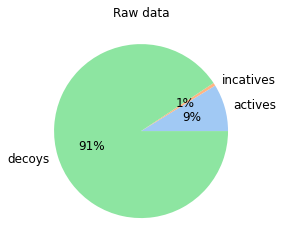

In [7]:
colors = sns.color_palette('pastel')[0:5]
data = [active_size, inactive_size, decoys_size]
labels = ['actives', 'incatives', 'decoys']
plt.pie(data, labels=labels, colors = colors, autopct='%.0f%%', textprops={"fontsize":12})
plt.title('Raw data')
# plt.show()
plt.savefig(f'{pics}/raw_data.png')

#### Our way to deal with imbalance - Combine inactives and decoys

In [8]:
size = active.shape[0] - inactive.shape[0]
split_decoys = decoys[:size]

In [9]:
balanced_data = pd.concat([active, inactive, decoys], ignore_index=True)
balanced_data

,smiles,label
0,c1cc2c(c(c1)Br)c(c[nH]2)CCOc3nc(c4c(n3)n(cn4)[...,1
1,c1cc2c(cc1Br)c(c[nH]2)CCOc3nc(c4c(n3)n(cn4)[C@...,1
2,c1cc2c(cc1Br)[nH]cc2CCOc3nc(c4c(n3)n(cn4)[C@H]...,1
3,c1cc2c(cc1CCNc3nc(c4c(n3)n(cn4)C5[C@@H]([C@@H]...,1
4,c1cc2c(cc1Cl)-c3c(c(nc(n3)N)c4ccc(o4)Br)C2,1
...,...,...
34787,Cc1ccc(cc1)NS(=O)(=O)c2cc(ccc2OC)C(=O)O[C@@H](...,0
34788,Cc1cc(nc(n1)N/C(=N\C(=S)NC[C@H]2CCCO2)/N3CCN(C...,0
34789,C[C@H](C(=O)Nc1ccc(c(c1)[N+](=O)[O-])F)OC(=O)C...,0
34790,COC(=O)[C@@]1(C[C@@H]([C@@H]([C@@H](O1)COP(=O)...,0


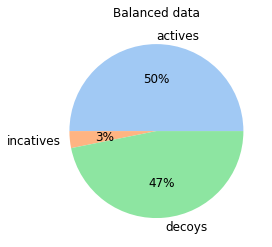

In [10]:
colors = sns.color_palette('pastel')[0:5]
data = [active_size, inactive_size, split_decoys.shape[0]]
labels = ['actives', 'incatives', 'decoys']
plt.pie(data, labels=labels, colors = colors, autopct='%.0f%%', textprops={"fontsize":12})
plt.title('Balanced data')
# plt.show()
plt.savefig(f'{pics}/balanced_data.png')

In [11]:
data = pd.concat([active, inactive, decoys], ignore_index=True)
data.shape

(34792, 2)

### Feature generation - RDKit Library

In [12]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator as MDC

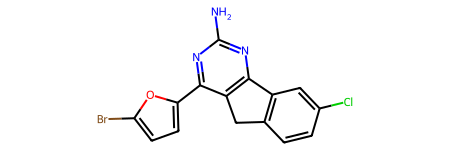

In [13]:
mol = Chem.MolFromSmiles(data.smiles[4])
mol

In [14]:
def RDkit_descriptors(data):
    mols = [Chem.MolFromSmiles(i) for i in data.smiles]
    desc_names = list(CalcMolDescriptors(mols[0]).keys())
    desc_names.append("label")
    mol_descs = []
    for i in tqdm(range(len(data))):
        descriptors = CalcMolDescriptors(mols[i])
        descriptors['label'] = data.label[i]
        mol_descs.append(descriptors)
    return mol_descs, desc_names

In [15]:
mol_descs,desc_names = RDkit_descriptors(data)

100%|████████████████████████████████████| 34792/34792 [08:02<00:00, 72.17it/s]


In [16]:
new_df = pd.DataFrame(mol_descs,columns=desc_names)
new_df

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,label
0,10.337455,10.337455,0.057778,-1.272753,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,1
1,10.335047,10.335047,0.059736,-1.271941,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,1
2,10.333078,10.333078,0.061184,-1.271281,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,1
3,10.355554,10.355554,0.205346,-1.235039,0.369988,25.218750,440.504,412.280,440.217203,170,...,0,0,0,0,0,0,0,0,0,1
4,6.090409,6.090409,0.226017,0.226017,0.547921,12.285714,362.614,353.542,360.961752,104,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34787,12.933117,12.933117,0.026874,-4.100987,0.602223,14.468750,461.496,438.312,461.125671,170,...,1,0,0,0,0,0,0,0,1,0
34788,5.666491,5.666491,0.191419,0.191419,0.400631,19.187500,455.592,426.360,455.221578,170,...,0,0,0,0,0,0,0,0,0,0
34789,13.336315,13.336315,0.076157,-3.927724,0.337664,12.322581,451.432,433.288,451.084949,164,...,1,0,0,0,0,0,0,0,0,0
34790,13.414551,13.414551,0.220101,-4.286701,0.417596,25.687500,468.395,443.195,468.118534,174,...,0,0,0,0,0,0,0,0,0,0


In [17]:
new_df.to_csv(f'{tables}/all_desc.csv',index=False)

## Can start from here

In [18]:
new_df = pd.read_csv(f'{tables}/desc.csv')

In [24]:
X = new_df.iloc[:,:-1]
y = new_df.label
X

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.337455,10.337455,0.057778,-1.272753,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,0
1,10.335047,10.335047,0.059736,-1.271941,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,0
2,10.333078,10.333078,0.061184,-1.271281,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,0
3,10.355554,10.355554,0.205346,-1.235039,0.369988,25.218750,440.504,412.280,440.217203,170,...,0,0,0,0,0,0,0,0,0,0
4,6.090409,6.090409,0.226017,0.226017,0.547921,12.285714,362.614,353.542,360.961752,104,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,12.319151,12.319151,0.017230,-3.862462,0.430330,16.000000,404.404,388.276,404.079055,146,...,0,1,0,0,0,0,0,0,0,0
6096,13.479540,13.479540,0.089593,-3.870532,0.661537,30.133333,433.490,410.306,433.141990,160,...,0,0,0,0,0,0,0,0,0,1
6097,13.479540,13.479540,0.089593,-3.870532,0.661537,30.133333,433.490,410.306,433.141990,160,...,0,0,0,0,0,0,0,0,0,1
6098,11.109896,11.109896,0.052139,-1.484804,0.591959,33.259259,379.321,362.185,379.090331,144,...,0,0,0,0,0,0,0,0,0,0


In [20]:
X.shape

(6100, 210)

### Filtering - deleting invariant data and highly correlated data

In [21]:
# from sklearn.feature_selection import VarianceThreshold

# def filter_data(X):
#     corr_matrix = X.corr().abs()
#     upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
#     to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
#     X.drop(to_drop, axis=1, inplace=True)
    
#     threshold = 0.9
#     sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
#     X = sel.fit_transform(X)
#     return X

# X = filter_data(X)

In [28]:
def filter_data(X):
    correlation_threshold = 0.9
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]

    # Extract column names before dropping
    column_names = X.columns
    X = X.drop(to_drop, axis=1)
    
    variance_threshold = 0.9
    sel = VarianceThreshold(threshold=(variance_threshold * (1 - variance_threshold)))
    X = sel.fit_transform(X)
    kept_features = sel.get_support(indices=True)
    X = pd.DataFrame(X, columns=column_names[kept_features])

    return X

X = filter_data(X)

In [29]:
X

,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,MaxPartialCharge,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_CHGHI,BCUT2D_CHGLO,...,fr_NH1,fr_alkyl_carbamate,fr_allylic_oxid,fr_azide,fr_benzodiazepine,fr_bicyclic,fr_epoxide,fr_ester,fr_isocyan,fr_isothiocyan
0,10.337455,-1.272753,23.375000,505.329,79.918731,-2.326422,9.103951,-0.051090,1.375036,1276.322883,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.335047,-1.271941,23.375000,505.329,79.918731,-2.326422,9.103026,-0.051090,1.367373,1276.322883,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.333078,-1.271281,23.375000,505.329,79.918731,-2.326422,9.103025,-0.051090,1.360843,1276.322883,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.355554,-1.235039,25.218750,440.504,16.562573,-2.326488,5.825210,-0.051059,1.323034,1119.239263,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.090409,0.226017,12.285714,362.614,79.918731,-2.005563,9.101988,0.552888,1.976391,875.350445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,12.319151,-3.862462,16.000000,404.404,32.233272,-2.415622,7.923083,-0.221879,1.710463,1011.077106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6096,13.479540,-3.870532,30.133333,433.490,32.238546,-2.592741,7.879540,-0.132775,1.454677,1041.505652,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6097,13.479540,-3.870532,30.133333,433.490,32.238546,-2.592741,7.879540,-0.132775,1.454677,1041.505652,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6098,11.109896,-1.484804,33.259259,379.321,16.756240,-2.624679,5.453392,-0.387812,1.490142,793.461585,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Scaling

In [31]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Data split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_test.value_counts()

1    327
0    283
Name: label, dtype: int64

### SVC

In [33]:
from numpy import mean
from sklearn import svm
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
svc = svm.SVC(random_state=0)

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
param_grid = {'C':[1, 10, 100],
                  'gamma':[0.01,0.001],
                 'kernel': ['rbf']}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(svc, param_grid, cv=cv, scoring=scoring, refit='AUC', verbose=1)

%time grid.fit(X_train, y_train)

print()
print(grid.best_params_)

y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)

score = roc_auc_score(y_test, y_pred)
print("Mean ROC AUC:", score)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
disp.plot()
# plt.show()
plt.savefig(f'{pics}/conf_scaled.jpg')

# Recheck

In [ ]:

svc = svm.SVC(C=100, gamma=0.001)

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# cm = confusion_matrix(y_test, y_pred)
# print("Accuracy:", accuracy)

# score = roc_auc_score(y_test, y_pred)
# print("Mean ROC AUC:", score)

print(classification_report(y_test, y_pred))

In [ ]:
svc_filename = f'{path_model}/svc.sav'
joblib.dump(svc, svc_filename)

In [ ]:
# svc = joblib.load(svc_filename)

### Plotting the result

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()
# plt.show()
plt.savefig(f'{pics}/conf_scal.jpg')

### SVC 2

In [ ]:
svc_2 = svm.SVC(C=1, gamma=0.0001)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(svc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=3)

svc_2 = svm.SVC(C=1, gamma=0.0001)
accuracy = cross_val_score(svc, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, verbose=3)
print('Mean ROC AUC: %.3f' % mean(scores))
print('Accuracy: %.3f' % mean(accuracy))

In [ ]:
svc_2_filename = f'{path_model}/svc_2.sav'
joblib.dump(svc_2, svc_2_filename)

In [ ]:
# svc_2 = joblib.load(svc_2_filename)

In [ ]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [ ]:
Z = svc_2.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title(titles[i])


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# accuracy_nb = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy_nb)

# score = roc_auc_score(y_test, y_pred)
# print("Mean ROC AUC:", score)

print(classification_report(y_test, y_pred))

In [ ]:
gaus_filename = f'{path_model}/gaussian.sav'
joblib.dump(nb, gaus_filename)

In [ ]:
# nb = joblib.load(gaus_filename)

### Logistic Regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression

In [ ]:
SEED = 42

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

lr = Pipeline([('p_trans', PowerTransformer(method='yeo-johnson', standardize=True)),
               ('lr', LogisticRegression(solver='liblinear',
                                         penalty='l1',
                                         max_iter=200,
                                         class_weight='balanced',
                                         random_state=SEED)
               )])

unscaled_lr = Pipeline([('lr', LogisticRegression(solver='liblinear',
                                         penalty='l1',
                                         max_iter=200,
                                         class_weight='balanced',
                                         random_state=SEED)
               )])

scores = cross_val_score(estimator=lr, X=X, y=y, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)

print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

lr.fit(X_train, y_train);

In [ ]:
df_score = pd.DataFrame(data={'score': lr['lr'].coef_[0]}, index=left_columns).sort_values(by='score')
# df.plot(kind='barh', grid=True, figsize=(6,6), legend=False)

In [ ]:
df_score

In [ ]:
y_pred = lr.predict(X_test)

# score = roc_auc_score(y_test, y_pred)
# print("Mean ROC AUC:", score)

# accuracy_nb = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy_nb)

print(classification_report(y_test, y_pred))

#### We have high accuracy and high AUC score in classification, it's better to go to regression to better progress

In [ ]:
lofit_filename = f'{path_model}/svc.sav'
joblib.dump(lr, logit_filename)

In [ ]:
# lr = joblib.load(logit_filename)

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
values = [i for i in range(1, 21)]
train_scores = []
test_scores = []
for i in values:
    model = DecisionTreeClassifier(max_depth=i)

    model.fit(X_train, y_train)

    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    
    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

## Plot

In [ ]:
plt.figure(1, figsize=(8,8))
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xticks(range(1, 21))
plt.grid()
plt.title('DecisionTreeClassifier')
plt.ylabel('Accuracy')
plt.xlabel('Max depth')
# plt.show()
plt.savefig(f'{pics}/clf_dtree_balanced.png')

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

values = [i for i in range(1, 21)]
train_scores = []
test_scores = []
for i in values:
    rf = RandomForestClassifier(max_depth=i)

    model.fit(X_train, y_train)

    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    
    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

In [ ]:
plt.figure(1, figsize=(8,8))
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xticks(range(1, 21))
plt.grid()
plt.title('RandomForestClassifier')
plt.ylabel('Accuracy')
plt.xlabel('Max depth')
# plt.show()
plt.savefig(f'{pics}/clf_rf_balanced.png')